# Analyzing NYC High School Data

One of the most controversial issues in the U.S. educational system is the efficacy of standarized tests and if they're unfair to certain groups. We'll analyze this context by investigating the correlations between [SAT scores](https://en.wikipedia.org/wiki/SAT) and other demographic factors, such as race, gender or income. 

To do so, we'll need the information stored in the following datasets:
* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): SAT scores for eah high school in New York City.
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt): Attendance information for each school in New York City.
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): Information on class size for each school.
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school.
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a): The percentage of students who graduated, and other outcome information.
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j): Demographic information for each school.
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8): Surveys of parents, teachers, and students at each school.

The main aim of this project will be to first clean and combine all the datasets above to later find correlations and see if there are any interesting differences between different demographic groups.

## Read in the Data and Import Libraries

### 1. Read in csv files

First of all, we'll import all the libraries needed and store all the csv datasets in the same variable (a dictionary in this case).

In [4]:
# Import libraries
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
# Store all datasets in a dictionary called data

#It would be very useful if you provide a way to programatically download all required datasets so you just need
#to run this notebook instead of having to manually download all of them one by one

data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]
data = {}
for f in data_files:
    # Try to use a relative path here. Otherwise anyone opening this notebook should have to build the path again.
    # i.e: Linux or Mac users won't have a C:/ device to start with, leading to a lot of errors
    d = pd.read_csv('C:/Users/User/Desktop/Dataquest/3.Data_Cleaning/datasets/schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Desktop/Dataquest/3.Data_Cleaning/datasets/schools/ap_2010.csv'

### 2. Read in the surveys

The survey information is in two files with *.txt* format, so we need to read them using a different encoding than before. Then we'll concatenate both datasets and select the columns we are interested in. Finally, the single survey dataframe'll be stored in the ```data``` dictionary.

In [8]:
# Read and concatenate the surveys datasets

# Same here, use realtive paths, if you download all datasets programatically, it will be even easier,
# as you will know where the data will be, relative to this notebook's location in the file system
all_survey = pd.read_csv('C:/Users/User/Desktop/Dataquest/3.Data_Cleaning/datasets/schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('C:/Users/User/Desktop/Dataquest/3.Data_Cleaning/datasets/schools/survey_d75.txt', delimiter='t', encoding='windows-1252')

survey = pd.concat([all_survey, d75_survey], axis=0)

# Select the columns of interest

#I don't see any reason for this operation to be necessary so far. survey is a object (dictionary) with a 'dnn'
#property in place. You are creating a new property 'DBN' and pointing it to the property that was already present.
#Also, you might be creating a circular dependency here, which is not a very good practice.
#Again, it might have sense given the context of the notebook as I could be missing something, but it does no really
#seem necessary. Why just don't use 'dbn'?
survey['DBN'] = survey['dbn']

# Hard to know whitout checking the data, but would be any way to retrieve the required fields without
# hardcoding (explicitly writing them down one by one) them?

survey_fields = [
    #Same as above, why create a new DBN property instead of using the already existing dbn?
    'DBN', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]

# I think this is not a good practice, the variable survey was instantiated before and was holding X data, here
# you are reassigning its value to what 'survey.loc[:,survey_fields].copy()' returns, so all data that 'survey' 
# was holding previously has no pointer now. Also for readability, would be better to

# new_var_name = survey.loc[:,survey_fields].copy()
survey = survey.loc[:,survey_fields].copy()

# Store survey inside data


# Following above, even: data['survey'] = survey.loc[:,survey_fields].copy()
data['survey'] = survey
print(data['survey'].columns)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Desktop/Dataquest/3.Data_Cleaning/datasets/schools/survey_all.txt'

## Data Cleaning

### 1. Add DBN columns

We are going to combine the dataframes using a column named ```DBN```, so it is essential to have it in all of them. This information is stored in the ```dbn``` column inside ```hs_directory```; so all we have to do is changing the name from ```dbn``` to ```DBN```. 

We also notice that the ```DBN``` columns in the ```sat_results``` data is just a combination of the ```CSD``` and ```SCHOOL CODE``` columns in the ```class_size``` dataframe. The main difference is that the ```DBN``` is padded, so that the ```CSD``` portion of it always consists of two digits. That means that we have to create a function that adds a leading ```0``` to the ```CSD``` if its length is less than two digits long. Once the function is applied to the ```CSD``` column, we can create the ```DBN``` column by using the addition operator (```+```) to combine the values in the ```CSD``` and ```SCHOOL CODE``` columns.

In [3]:
# Create DBN column in data['hs_directory']
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

# Pad_csd function
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation

# Create padded_csd column in data['class_size']  
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
# Create DBN column (padded_csd+SCHOOL CODE) in data['class_size']
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

#Check the results
print(data['sat_results']['DBN'].head())
print(data['hs_directory']['DBN'].head())
print(data['class_size']['DBN'].head())

0    01M292
1    01M448
2    01M450
3    01M458
4    01M509
Name: DBN, dtype: object
0    17K548
1    09X543
2    09X327
3    02M280
4    28Q680
Name: DBN, dtype: object
0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object


### 2. Convert columns to numeric

In this point, we should create a single column that totals up the SAT scores for the different sections of the exam (named ```SAT Math Avg. Score```, ```SAT Critical Reading Avg. Score``` and ```SAT Writing Avg. Score``` in ```sat_score``` data). This makes it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

Next, it may be interesting to parse the latitude and longitude coordinates for each school. This enables to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field ```Location 1``` in the ```hs_directory``` dataset.

In [4]:
# Sat_score column creation
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Create columns for latitude and longitude
def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat

def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

### 3. Condense datasets: Unique values in DBN columns

The following step will focus on getting unique values in the ```DBN``` columns.

In [5]:
class_size = data['class_size']
# Only high school
class_size = class_size[class_size['GRADE '] == '09-12']
# Most common program type by far is GEN ED
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
# Groupby DBN and calculate mean for the rows with common DBN to obtain unique values
class_size = class_size.groupby('DBN').agg(numpy.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

# We only select the most recent year to have unique values in DBN
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

# We only select the most recent kohort years and total kohort to have unique values
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

### 4. Convert AP scores to numeric

Before combining the datasets, the last thing to do is converting the [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) test scores from strings to numeric values. AP exams help students earn college credit and they have a ```1``` to ```5``` scale; where ```3``` or higher is a passing score.

Students who attend academically challenging institutions are more likely to take this exam compared with those whose schools have lack funding or acadmeic rigor. So it will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert some columns of interest in the ```ap_2010``` data set to numeric values first. The columns are:
* ```AP Test Takers ```
* ```Total Exams Taken```
* ```Number of Exams with scores 3 4 or 5```

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

## Combine the datasets

### 1. Merging datasets in 'combined'

Now it's time to combine all the datasets and replace the ```NaN``` values.

In [7]:
combined = data['sat_results']
# Left merge because data['ap_2010'] and data['graduation'] have many null values
combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

# Inner merge because these datasets have fewer null values
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')
    
# Replace NaN values with means of the column
means = combined.mean(axis=0)
combined = combined.fillna(means)

# Replace remaining NaN values with 0
combined = combined.fillna(0)

# Check the results
print(combined['DBN'].isna().sum())

0


C:\Users\User\AppData\Local\Temp\ipykernel_5124\1733514059.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = combined.mean(axis=0)


## Add a school district column for mapping

Once our data is cleaned and merged, mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the dataset that specifies the school district helps us accomplish this.

In [8]:
# The school district refers to the first two characters of the DBN
def get_first_two_chars(dbn):
    return dbn[0:2]

combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)
print(combined['school_dist'].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


## Data Analysis and Visualization

### 1. Find correlations

It's time to find any correlations between columns and ```sat_score``` in order to determine which might be interesting to plot out or investigate further. Afterwards, we'll perform more analysis and create maps using the columns we've identified.

In [9]:
# Correlations between all columns of the dataset
correlations = combined.corr()
# Correlations between sat_score with the rest of columns
correlations_positive = correlations["sat_score"].sort_values(ascending=False)
correlations_negative = correlations['sat_score'].sort_values()

# Higest correlation values
print('Columns with highest correlation values:\n', correlations_positive.head(20))

#Lowets correlation values
print('Columns with lowest correlation values:\n', correlations_negative.head(20))

Columns with highest correlation values:
 sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                   

```SAT Critical Reading Avg. Score```, ```SAT Math Avg. Score```, ```SAT Writing Avg. Score``` and ```sat_score``` are strongly correlated, since the last one was created  from a sum of all 3 SAT subsections. We can also make some other observations:
* Focusing on race factors, it seems that some groups (asian and white students) are related to high SAT scores, while hispanic and black students obtain lower values.
* The columns which correspond to AP scores (```AP test Takers```, ```Total Exams Taken``` and ```Number of Exams with scores 3 4 or 5```) are correlated positively with ```sat_score```.
* On the other hand, socioeconomic indicators (stored in ```frl_percent```, ```sped_percent``` and ```ell_percent``` columns) have a strong negative correlation with ```sat_score```. 
* The positive correlation between the columns ```total_enrollment``` and ```total_students``` with ```sat_score``` may be quite surprising; since we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true.

### 2. Plotting Survey Correlations

Now we'll analyze and plot out the correlations between ```sat_score``` and survey fields.

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

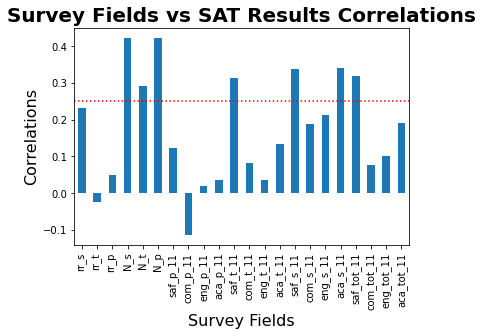

In [11]:
%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.bar()
plt.title('Survey Fields vs SAT Results Correlations', fontsize=20, fontweight='bold')
plt.xlabel('Survey Fields', fontsize=16)
plt.ylabel('Correlations', fontsize=16)
plt.axhline(y = 0.25, color = 'r', linestyle = ':')
plt.rcParams.update({'figure.figsize':(10,8)})
plt.show()

There are high values in the correlations between ```N_s```, ```N_t``` and ```N_p``` with ```sat_score```. Since the columns are related to ```total_enrollment```, we are not surprised with these results.

How students and teacher perceive safety (information stored in the columns ```saf_t_11``` and ```saf_s_11```) correlate positively with ```sat_score```. This affirmation also makes sense, since is easier to have a good academical performance in a safe environment.

The column ```aca_s_11``` (student perception of academic standards) also has a positive correlation with ```sat_score```. Nevertheless, there is not such a relation between ```sat_score``` and the columns ```aca_t_11``` (teacher perception of academic standards) and ```aca_p_11```(parent perception of academic standards).

In conclusion, survey fields that have strong correlation with ```sat_score``` are:
* ```N_s```
* ```N_t```
* ```N_p```
* ```saf_t_11```
* ```saf_s_11```
* ```aca_t_11```
* ```saf_tot_11```

### 3. Exploring Safety and SAT Scores

In the graphic above, we have seen that columns related to safety (```saf_t_11``` and ```saf_s_1```) have a positive correlation with ```sat_score```. So now, we'll dig into this relatonship and try to figure out which schools have low safety scores.

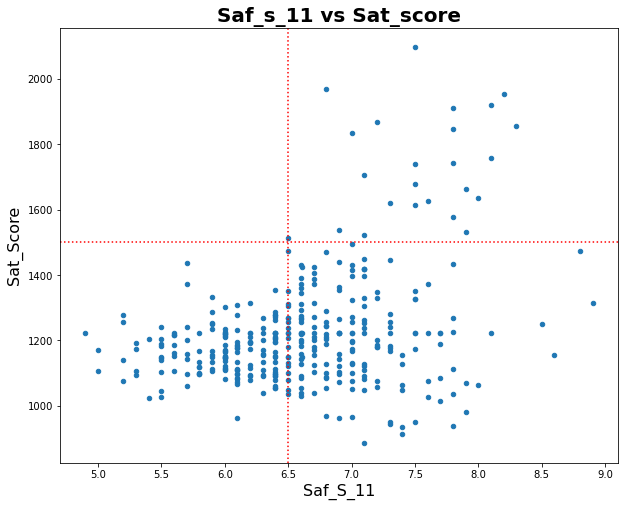

In [12]:
# Scatterplot between saf_s_11 and sat_score
combined.plot.scatter('saf_s_11', 'sat_score')
plt.title('Saf_s_11 vs Sat_score', fontsize=20, fontweight='bold')
plt.xlabel('Saf_S_11', fontsize=16)
plt.ylabel('Sat_Score', fontsize=16)
plt.rcParams.update({'figure.figsize':(10,8)})
plt.axhline(y = 1500, color = 'r', linestyle = ':')
plt.axvline(x = 6.5, color = 'r', linestyle = ':')
plt.show()

We can see that the correlation between ```saf_s_11``` and ```sat_score``` is not very strong: There are few schools with high safety perception and high SAT results, whereas on the other hand, other  few schools could be found in the area where both columns have low values. It seems that the majority of schools cluster in the central part of the plot, where values in the columns are intermediate. Nevertheless, we should higlight that all schools with less than 6.5 in safety perception get low (lower tha 1500) ```sat_score``` values. 

### 4. Safety for each Borough

Now we'll compute average safety scores for each borough

In [13]:
# Groupby borough and compute the means
safety_borough = combined.groupby('boro').agg(numpy.mean)
safety_borough = safety_borough[['saf_s_11', 'saf_t_11']]
print('Safety values for each borough:\n', safety_borough)

Safety values for each borough:
                saf_s_11  saf_t_11
boro                             
Bronx          6.606577  7.026882
Brooklyn       6.370755  6.985849
Manhattan      6.831370  7.287778
Queens         6.721875  7.365625
Staten Island  6.530000  7.210000


After seeing the results above, we can conclude that the safety perception of students and teachers in all boroughs have similar values. However, between all boroughs Manhattan and Queens have the highest values fot both groups; whereas the lowest correspond to Brooklyn and Staten Island. We should also point out that all safety perception values are higher for teachers than for their students.

### 5. Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at schools:
* ```white_per```
* ```asian_per```
* ```black_per```
* ```hispanic_per```

By plotting out the correlations between these columns and ```sat_score```, we can determine whether there are any racial differences in SAT performance.

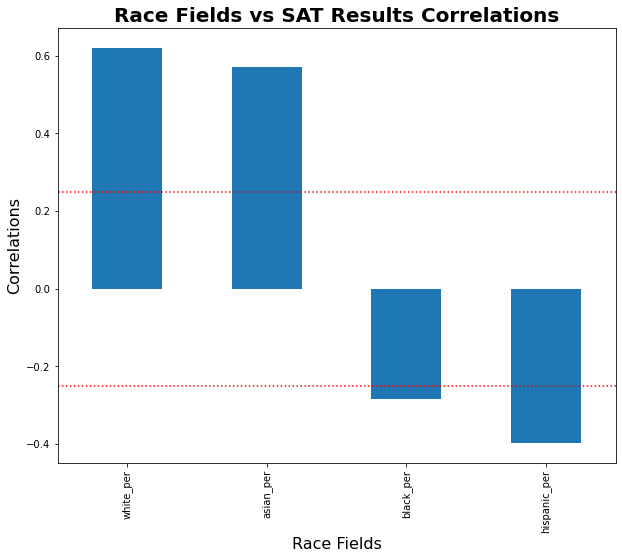

In [14]:
# Race fields correlations with SAT results
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race_fields].plot.bar()
plt.title('Race Fields vs SAT Results Correlations', fontsize=20, fontweight='bold')
plt.xlabel('Race Fields', fontsize=16)
plt.ylabel('Correlations', fontsize=16)
plt.axhline(y = 0.25, color = 'r', linestyle = ':')
plt.axhline(y = -0.25, color = 'r', linestyle = ':')
plt.rcParams.update({'figure.figsize':(10,8)})
plt.show()

All races have strong correlation with the ```sat_score``` columns: On the one hand, ```white_per``` and ```asian_per``` fields correlate positively with values around 0.55-0.6. On the other hand, the columns regarding to black and hispanic students correlate negatively with ```sat_score```. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

Since the lowest ```sat_score``` values correspond to ```hispanic_per``` columns, we'll investigate this correlation deeper.

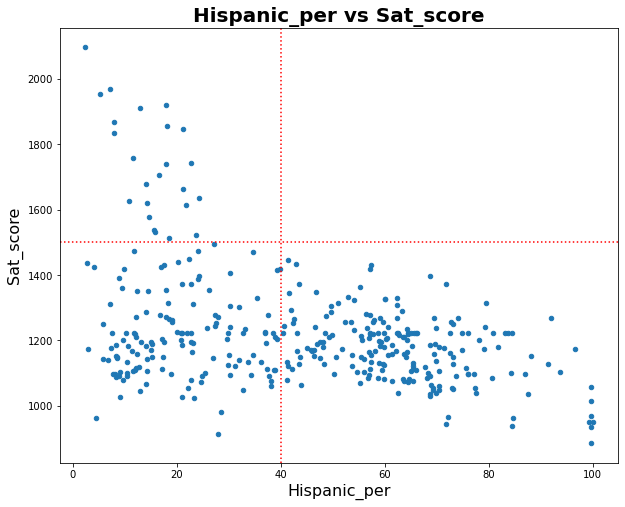

In [15]:
# Scatterplot between hispanic_per and sat_score
combined.plot.scatter('hispanic_per', 'sat_score')
plt.title('Hispanic_per vs Sat_score', fontsize=20, fontweight='bold')
plt.xlabel('Hispanic_per', fontsize=16)
plt.ylabel('Sat_score', fontsize=16)
plt.rcParams.update({'figure.figsize':(10,8)})
plt.axhline(y = 1500, color = 'r', linestyle = ':')
plt.axvline(x = 40, color = 'r', linestyle = ':')
plt.show()

In the first part of the graphic, there are some schools with few (less than 20%) hispanic students obtaining high ```sat_score``` values. Nevertheless, there are more schools getting low SAT scores values with the same amount of hispanic students. The negative correlation becomes clearer as the number of hispanic students increases: For example, no school with more than 40% Hispanic students scores higher than 1500 in ```sat_score```.

It may be interesting to compare the type of schools that have many and few hispanic students.

In [16]:
# Schools with many hispanic students
many_hispanic = combined[combined['hispanic_per']>95]
print('Schools with the highest hispanic students percentages:\n', many_hispanic['SCHOOL NAME'])

Schools with the highest hispanic students percentages:
 44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems that a great amount of the students in these schools are recent inmigrants in the US. The fact that the schools have a lot of sudents who are currently studying English would explain the negative correlation between ```hispanic_per``` and ```sat_score```.

In [17]:
# Schools with few hispanic students and high SAT score values
few_hispanic = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
print('Schools with low hispanic students percentages and high SAT scores:\n', few_hispanic['SCHOOL NAME'])

Schools with low hispanic students percentages and high SAT scores:
 37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above are specialized in the field of science and technology, and the students have to pass an entrance exam to enroll there. This may not explain the low amount of hispanic students, but could be one of the reasons why the schools obtain such a high values in ```sat_score```.

### 6. Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:
* ```male_per```
* ```female_per```

We can plot out the correlations between each percentage and ```sat_score``` to find out if there are gender differences in SAT performance.

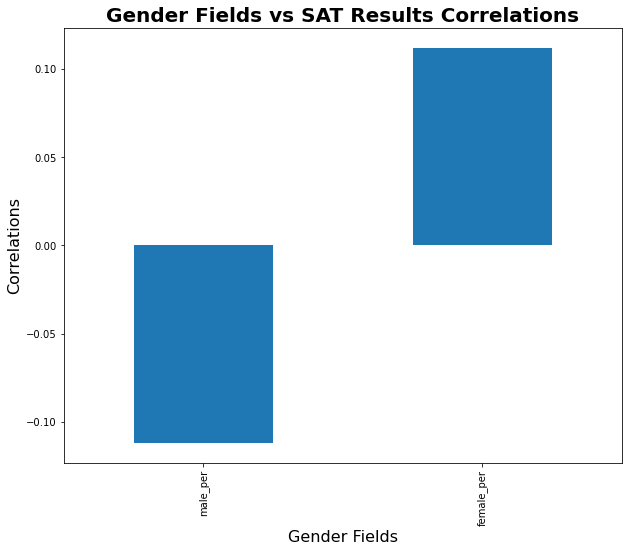

In [18]:
# Bar correlations between percentages and sat_score
gender_fields = ['male_per', 'female_per']

combined.corr()['sat_score'][gender_fields].plot.bar()
plt.title('Gender Fields vs SAT Results Correlations', fontsize=20, fontweight='bold')
plt.xlabel('Gender Fields', fontsize=16)
plt.ylabel('Correlations', fontsize=16)
plt.rcParams.update({'figure.figsize':(10,8)})
plt.show()

The graphic above shows that schools with high percentage of females positively correlate with SAT scores, while a high percentage of males at school correlates negatively with the test results. Nevertheless, neither correlation is very strong.

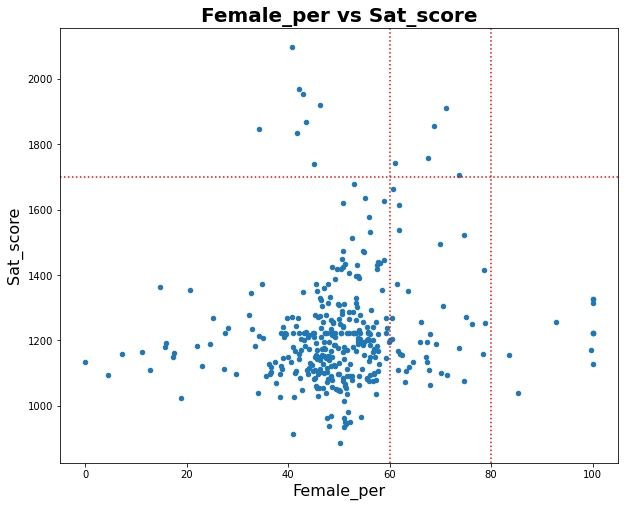

In [19]:
# Scatterplot between female_per and sat_score
combined.plot.scatter('female_per', 'sat_score')
plt.title('Female_per vs Sat_score', fontsize=20, fontweight='bold')
plt.xlabel('Female_per', fontsize=16)
plt.ylabel('Sat_score', fontsize=16)
plt.rcParams.update({'figure.figsize':(10,8)})
plt.axhline(y = 1700, color = 'r', linestyle = ':')
plt.axvline(x = 60, color = 'r', linestyle = ':')
plt.axvline(x = 80, color = 'r', linestyle = ':')
plt.show()

Analyzing the scatter, we can affirm there is no real correlation between these columns: The majority of schools cluster in the zone with intermediate (```40``` to ```60```) pertentage values. However, there is a small cluster where both the female percentage (```60``` to ```80```) and SAT scores have high values, so it may be interesting to analyze deeper those values.

In [20]:
# Schools with many females and high SAT score values
many_girls = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
print('Schools with many females and high SAT scores:\n', many_girls['SCHOOL NAME'])

Schools with many females and high SAT scores:
 5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to be very selective liberal arts schools that have high academic standards.

### 7. Exploring AP Scores vs. SAT Scores

It makes sense that the number of students at a school who take AP exams would be highly correlated with the school's SAT scores, so we'll explore this relationship. Because ```total_enrollment``` is highly correlated with ```sat_score```, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [21]:
# Percentage of students taking AP test in each school
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
print(combined['ap_per'].head())

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64


           sat_score    ap_per
sat_score   1.000000  0.057171
ap_per      0.057171  1.000000


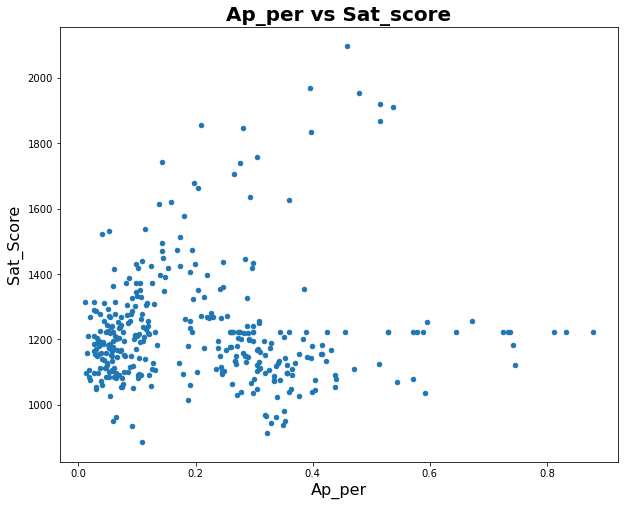

In [22]:
# Scatterplot between ap_per and sat_score
combined.plot.scatter('ap_per', 'sat_score')
plt.title('Ap_per vs Sat_score', fontsize=20, fontweight='bold')
plt.xlabel('Ap_per', fontsize=16)
plt.ylabel('Sat_Score', fontsize=16)
plt.rcParams.update({'figure.figsize':(10,8)})
print(combined[['sat_score','ap_per']].corr())

Although the correlation is not very strong, it looks like there is a positive relationship between students who take AP exams and their results in SAT scores.

### 8. Exploring Class Size vs SAT Scores

Going further with the analylsis, we'll explore the correlation between ```sat_score``` and ```AVERAGE CLASS SIZE```.

                    sat_score  AVERAGE CLASS SIZE
sat_score            1.000000            0.381014
AVERAGE CLASS SIZE   0.381014            1.000000


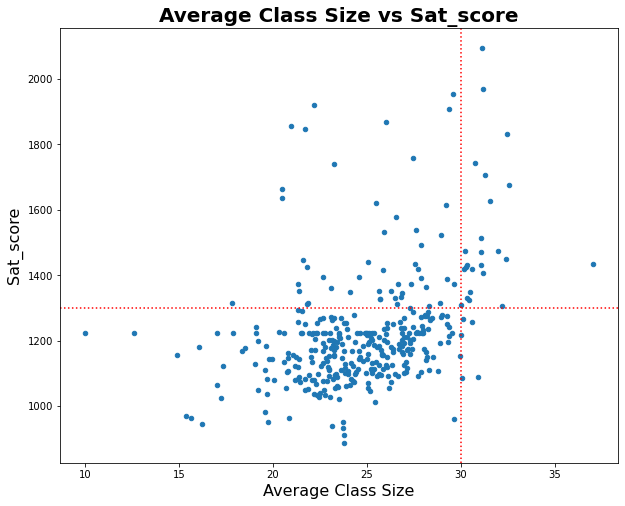

In [23]:
# Scatterplot between AVERAGE CLASS SIZE and sat_score
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')
plt.title('Average Class Size vs Sat_score', fontsize=20, fontweight='bold')
plt.xlabel('Average Class Size', fontsize=16)
plt.ylabel('Sat_score', fontsize=16)
plt.rcParams.update({'figure.figsize':(10,8)})
plt.axhline(y = 1300, color = 'r', linestyle = ':')
plt.axvline(x = 30, color = 'r', linestyle = ':')
print(combined[['sat_score','AVERAGE CLASS SIZE']].corr())

Although the correlation value is quite high, analyzing the graphic above it doesn't seem to be a strong correlation between the columns. The great majority of schools have a range of 20-30 students per class where SAT scores are generally below 1300. Nevertheless, we can see the correlation more clearly as class size increases: In schools with more than 30 students per class the SAT score exceeds 1300.

## Conclusion

After all the analysis carried out above, we can conclude that the ```sat_score``` column correlates to a greater or lesser extent with survey, race and gender fields; and with columns related to AP scores results and class size.

Referring to the objective established in the introduction, we can affirm that the demographic factors analyzed affect the result that students obtain in the SAT scores. Nevertheless, we could do a deeper analysis figuring out which neighborhoods have the best schools or investigating the differences between parent, teacher, and student responses to surveys.